In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import time
import tqdm
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
import pandas as pd
import h5py

import jax
import jax.numpy as jnp
from flax import linen as nn
from orbax.checkpoint import Checkpointer, PyTreeCheckpointHandler
from flax.core.frozen_dict import freeze, unfreeze

from queso.estimators.flax.dnn import BayesianDNNEstimator
from queso.io import IO

import visualizers.styles
visualizers.styles.plt_style('slides')

/Users/benjamin/Library/CloudStorage/OneDrive-UniversityofWaterloo/Desktop/1 - Projects/Quantum Intelligence Lab/queso/config.yaml
{'default_path': '/Users/benjamin/data/queso'}
/Users/benjamin/Library/CloudStorage/OneDrive-UniversityofWaterloo/Desktop/2 - Papers/paper_tools/visualizers/styles/slides.mplstyle


In [7]:
# io = IO(folder="2023-07-05_nn-estimator-n4-k4", verbose=False)
# io = IO(folder="2023-07-06_nn-estimator-n1-k1", verbose=False)
io = IO(folder="2023-07-13_calibration-samples-n1-ghz", verbose=False)
# io = IO(folder="2023-07-11_calibration-samples-n2-ghz-backup", verbose=False)

In [9]:
hf = h5py.File(io.path.joinpath("circ.h5"), "r")
print(hf.keys())
shots = jnp.array(hf.get("shots"))
probs = jnp.array(hf.get("probs"))
phis = jnp.array(hf.get("phis"))
hf.close()

n = shots.shape[2]
n_phis = shots.shape[0]
phi_range = (jnp.min(phis), jnp.max(phis))

<KeysViewHDF5 ['fi', 'mu', 'phis', 'probs', 'shots', 'theta', 'vn_ent']>


In [10]:
ckpt_dir = io.path.joinpath("ckpts")
ckptr = Checkpointer(PyTreeCheckpointHandler())  # A stateless object, can be created on the fly.
restored = ckptr.restore(ckpt_dir, item=None)
nn_dims = restored['nn_dims']

In [11]:
key = jax.random.PRNGKey(0)
model = BayesianDNNEstimator(nn_dims)

In [12]:
# model.apply({'params': restored['params']}, shots[:10, :10, :])

(1.508447217135611e-08+0j)


/var/folders/fk/gsbw4p3n6wxb9cs3bj47j0p00000gn/T/ipykernel_27695/3507020165.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


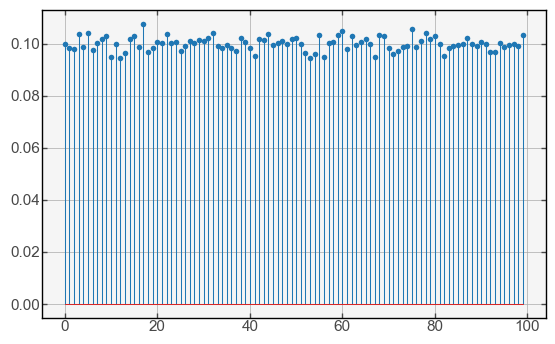

In [17]:
bit_strings = jnp.expand_dims(jnp.arange(2 ** n), 1).astype(jnp.uint8)
bit_strings = jnp.unpackbits(bit_strings, axis=1, bitorder='big')[:, -n:]

pred = model.apply({'params': restored['params']}, bit_strings)
pred = nn.activation.softmax(jnp.exp(pred), axis=-1)

fig, axs = plt.subplots(nrows=2, sharex=True)
colors = sns.color_palette('deep', n_colors=bit_strings.shape[0])
markers = cycle(["o", "D", 's', "v", "^", "<", ">", ])
lines = cycle(['-', '--', '-.', ':'])
for i in range(bit_strings.shape[0]):
    bit_string = ''.join(str(b) for b in bit_strings[i])
    marker = next(markers)
    axs[0].plot(
        jnp.linspace(phi_range[0], phi_range[1], pred.shape[1]) / jnp.pi,
        pred[i, :],
        ls='',
        marker=marker,
        color=colors[i],
        label=r"p($\phi_j | "+f"{bit_string}"+"$)",
    )

    axs[1].plot(
        phis / jnp.pi,
        probs[:, i],
        # ls=next(lines),
        ls='',
        marker=marker,
        color=colors[i],
    )
axs[0].set(ylabel=r"Posterior, p($\phi_j | b_i$)")
axs[0].set_ylim(bottom=0)
axs[1].set(ylabel=r"Likelihood, p($b_i | \phi_j$)")
axs[-1].set(xlabel=r"$\phi_j / \pi$")
axs[0].legend(loc='center left', bbox_to_anchor=(1.01, 0.5))

io.save_figure(fig, filename="posterior-dist.png")

plt.show()

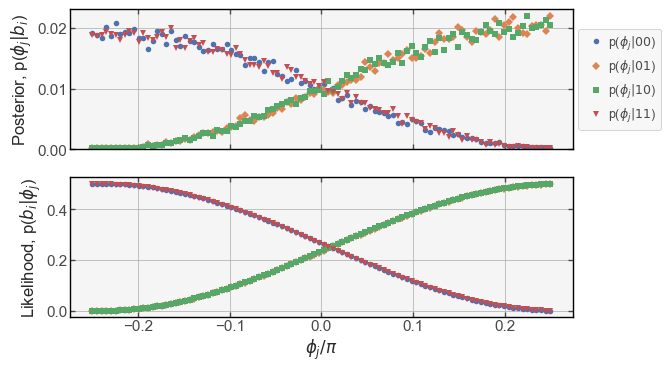

In [18]:
plot = True

phi_inds = jnp.array([0, 50, 100])
n_sequences = (1, 10, 100)

fig, axs = plt.subplots(nrows=len(n_sequences), sharex=True, figsize=(6.5, 6.0))
colors = sns.color_palette('deep', n_colors=phi_inds.shape[0])
markers = ["o", "D", 's', "v", "^", "<", ">", ]
for i, n_sequence in enumerate(n_sequences):

    key = jax.random.PRNGKey(time.time_ns())
    shot_inds = jax.random.randint(key, shape=(n_sequence,), minval=0, maxval=shots.shape[1])
    sequence = shots[phi_inds, :, :]
    sequence = sequence[:, shot_inds, :]

    pred = model.apply({'params': restored['params']}, sequence)
    pred = nn.activation.softmax(jnp.exp(pred), axis=-1)
    print(pred.shape)
    pred = jnp.log(pred).sum(axis=1)
    pred = jnp.exp(pred - pred.max(axis=1, keepdims=True))  # help with underflow in normalization
    pred = pred / pred.sum(axis=1, keepdims=True)

    print(pred.shape)
    # print(pred)

    ax = axs[i]
    for j in range(phi_inds.shape[0]):
        post = pred[j, :]
        ax.plot(
            jnp.linspace(phi_range[0], phi_range[1], post.shape[0]) / jnp.pi,
            post,
            ls='',
            marker=markers[i],
            color=colors[j],
            label=r"$\phi_{true}=$"+f"{phis[phi_inds[j]]/jnp.pi:0.2f}",
        )
    ax.set(title=f"{n_sequence} shots")
    ax.set(ylabel=r"p($\phi_j | \vec{b}$)")

axs[0].legend()
axs[-1].set(xlabel="$\phi_j/\pi$")
fig.tight_layout()
plt.show()

io.save_figure(fig, filename="sequence-posterior.png")


(3, 1, 100)
(3, 100)
(3, 10, 100)
(3, 100)
(3, 100, 100)
(3, 100)


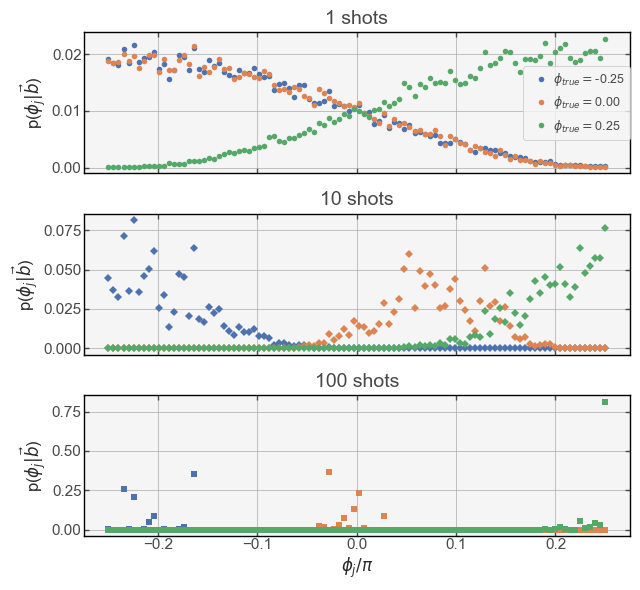

In [19]:
metrics = io.load_csv('metrics.csv')
fig, ax = plt.subplots()
ax.plot(metrics.step, metrics.loss)
ax.set(xlabel="Optimization step", ylabel="Loss")
io.save_figure(fig, filename="nn-loss.png")

plt.show()

In [609]:
print(probs.shape)

(200, 2)


[Text(0, 0.5, 'Entropy of entanglement'), Text(0.5, 0, 'Optimization Step')]

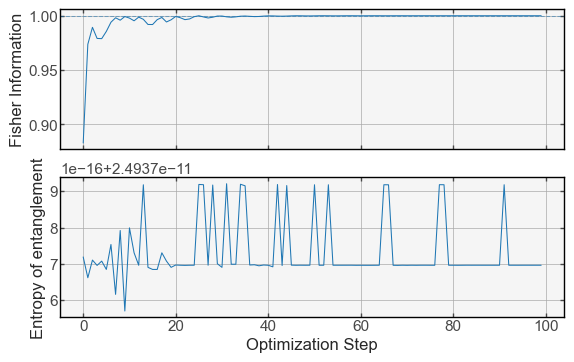

In [610]:
hf = h5py.File(io.path.joinpath("circ.h5"), "r")
print(hf.keys())
fi = jnp.array(hf.get('fi'))
vn_ent = jnp.array(hf.get('vn_ent'))
hf.close()

fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True)
axs[0].plot(fi)
axs[0].axhline(n**2, ls="--", alpha=0.5)
axs[0].set(ylabel="Fisher Information")
axs[1].plot(vn_ent)
axs[1].set(ylabel="Entropy of entanglement", xlabel="Optimization Step")